# Project 2 - Classification

In this project we will perform classification using Logistic regression, KNN-classification and Neural networks. We will use a subset of the widely used MNIST database of handwritten digits. The classification task is to predict the correct digit from a 28x28 pixel image of a handwritten digit.

We will start by importing some useful Python libraries and functions to help us out.

In [2]:
import numpy as np  # Used for its useful array data type and other functions.
import pandas as pd # Used to construct a DataFrame to hold the data.
 
from sklearn.linear_model import LogisticRegression # Logistic Regression
from sklearn.neighbors import KNeighborsClassifier  # KNN-classification
from sklearn.neural_network import MLPClassifier    # Neural Network

# Libraries and functions for plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm
matplotlib.rcParams.update({'font.size': 15})
import seaborn as sns

## Exploratory Data Analysis and Data Preprocessing

Lets have a look at the dataset. We will start by loading it from the file and figuring out how many instances and features we are working with.

In [3]:
mnist_df = pd.read_csv('mnist_subset.csv') # Loading dataset from file into a DataFrame
mnist_df.shape                             # Dimensionality of the DataFrame (#rows, #columns)

(42000, 785)

We have 42000 rows and 785 columns in the DataFrame. With 42000 instances we are starting to reach the limit of what we can comfortably work with without having to wait a long time for computations to finish. To make the dataset more managable we will only use a subsample of these instances. As a general rule keeping more instances will result in more accurate models, since they have been trained on more data. However, with more instances the computations associated with training and validation also take a longer time. 

We will use a subsample with 15000 instances in this project. This should be managable on most machines but if you have an older computer this might still be too much. If so feel free to use an even smaller subsample. If you have a more powerful computer and don't mind waiting feel free to use more instances as well.

In [4]:
mnist_df = mnist_df.sample(n=15000, random_state=123) # A random subsample of 15000 intstances from the dataset

Lets print the dataset description to get a better understanding of the data. 

In [5]:
mnist_df.describe() # Provides a summarized description of the dataset

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,15000.000000,15000.0,15000.0,15000.0,15000.0,15000.0,15000.0,15000.0,15000.0,15000.0,...,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.0,15000.0,15000.0,15000.0
mean,4.455533,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.250467,0.147667,0.063333,0.020867,0.019600,0.004133,0.0,0.0,0.0,0.0
std,2.879220,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.966455,5.278205,3.423853,2.099919,2.033624,0.506228,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,252.000000,253.000000,244.000000,62.000000,0.0,0.0,0.0,0.0


From the preview above we see that the first column is the label (target). Since we are classifying digits this column contains the integers from 0 to 9. The other 784 columns represent the pixels in the image. Since we have 28x28 images we have 784 pixels in total. Each pixel has a grayscale value between 0 and 255 where 0 corresponds to black, 255 corresponds to white and everything in between is a different shade of gray. 

Since we are working with image data the best way to understand it is to actually see the images. To do so we can reshape the pixels into a 28x28 array of grayscale values and plot the images using the function `imshow` from `matplotlib`. 

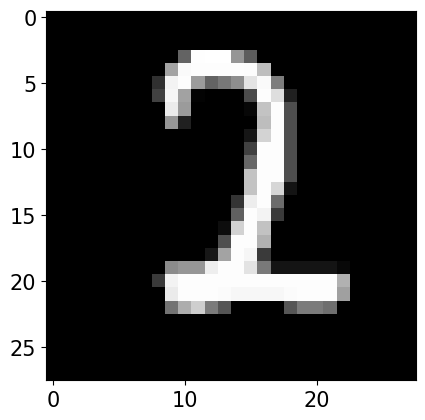

In [6]:
sample_row = mnist_df.iloc[0, 1:]                  # Sample row from dataset - 784 pixels
image = np.array(sample_row).reshape((28, 28))     # Reshaping pixels into 28x28 image
plt.imshow(image, cmap='gray', vmin=0, vmax=255);  # Plotting the image in grayscale

The image above is an example of an observation in our dataset and as a human it is easy to tell what digit it is. Lets see if we can teach the machine to do the same. 

Before applying any supervised learning method we need to split the data into a training set and a test set. We will set aside 30% of the dataset as the test set this time. We will also standardize the features in the same way that we did in the previous project. In this project standardization is particularly important to ensure that the gradient descent optimization procedures used to train Logistic regression and Neural networks converge nicely to a local optima. 

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

train, test = train_test_split(mnist_df, test_size=0.30, random_state=87443) # Splitting data into train and test

train_X = train.drop('label', axis=1) # Features in the training set
train_y = np.array(train['label']) # Target in the training set as numpy array

test_X = test.drop('label', axis=1) # Features in the training set
test_y = np.array(test['label']) # Target in the training set as numpy array

# Standardizing features (equation 2.2 in sml)
standardizer = StandardScaler()
train_X = standardizer.fit_transform(train_X)
test_X = standardizer.transform(test_X)

## Logistic Regression

We will start by applying Logistic regression to the dataset. Since there are no parameters to be set for Logistic regression we directly evaluate the results on the test set.When evaluating the results of a classification method one of the most common measures that we consider is the test accuracy. The test accuracy is simply the proportion of correctly classified observations in the test set. 

<strong>Task 1:</strong> Using the imported `LogisticRegression` class train a logistic regression model and save the predictions of this model on the test set in the variable `y_pred_logreg`. Complete the function `accuracy` which takes the true test labels `y_true` and the predicted labels `y_pred` and returns the test accuracy. Note that both of these objects are numpy arrays which are indexed just like regular lists.

In [11]:
model = LogisticRegression(solver='newton-cg') #Got error if not used, teacher helped solve it
model.fit(train_X, train_y)
y_pred_logreg = model.predict(test_X)  # Train a Logistic Regression model and save the test predictions here



In [12]:
model.score(test_X, test_y)

0.8875555555555555

In [13]:
def accuracy(y_true, y_pred):
    
    correct_predictions = 0
    total_samples = len(y_true)
    
    for i in range(total_samples):
        if y_true[i] == y_pred[i]:
            correct_predictions += 1
    
    return correct_predictions / total_samples

test_acc_logreg = accuracy(test_y, y_pred_logreg) # Accuracy of Logistic regression model
test_acc_logreg

0.8875555555555555

The test accuracy gives us a good general idea of how well the classification method works. It is easy to interpret and understand. If the test accuracy is 0.87 we know that 87% of the test observations were correctly classified. However, we have no idea about what went wrong in the 13% of cases when we had a misclassification. To get a more detailed understanding of the misclassifications we will use the confusion matrix. As the name suggests the confusion matrix gives us information about where the method is getting confused. The plot below shows the confusion matrix for the Logistic regression model.

In [14]:
from sklearn.metrics import confusion_matrix

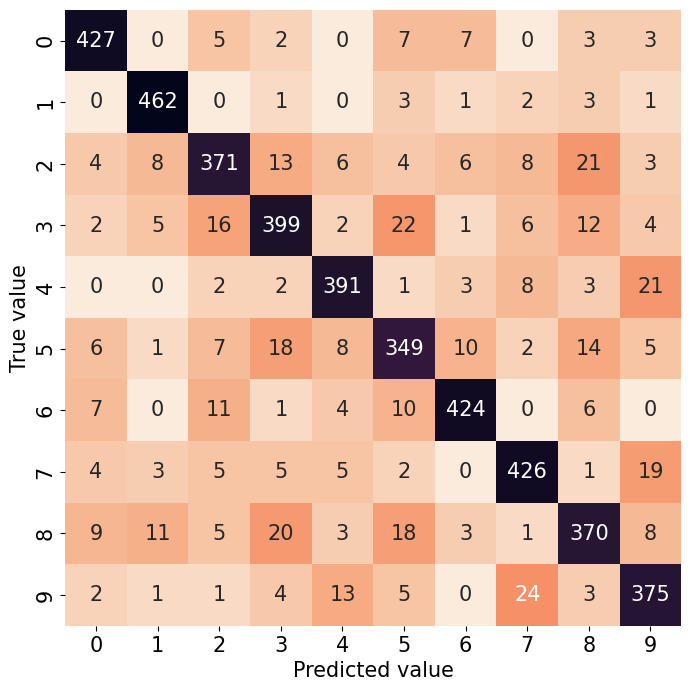

In [15]:
def plot_confusion_matrix(confusion_matrix):
    '''
    Plots a heatmap of a confusion matrix.
    '''
    fig = plt.figure(figsize=(8,8))
    sns.heatmap(confusion_matrix, annot=True, square=True, fmt='.5g', 
                cmap='rocket_r', norm=PowerNorm(0.5), cbar=False)
    plt.ylabel('True value')
    plt.xlabel('Predicted value')

cm = confusion_matrix(test_y, y_pred_logreg) # Constructs the confusion matrix
plot_confusion_matrix(cm)                

The matrix shows us the number of test observations in each category. The diagonal shows correctly classified observations and off-diagonal values show the misclassification count between two different classes. For example in some cases when the true label was 9 the Logistic regression model predicted 4 instead. It never confused a 0 for a 1 or vice-versa so we see that it definitively struggled more with some classifications than others. 

## KNN-Classification

You may have noticed that we did not create a validation set this time. That is because we will use cross-validation instead to choose the optimal value for k. We will use the `KNeighborsClassifier` class and the `cross_val_score` functions from `sklearn`. Make sure to read the documentation before trying to solve the task. Note that by default `cross_val_score` evaluates the accuracy when used with the `KNeighborsClassifier`.

<strong>Task 2:</strong> Using the `KNeighborsClassifier` class and the `cross_val_score` function perform 5-fold cross-validation for k=2,6,10,14. For each k evaluate the accuracy of the KNN-classifier. If done correctly `cross_val_score` should yield an array with 5 accuracy scores, one for each cross-validation fold. Save the optimal k in the variable `optimal_k`.

In [16]:
from sklearn.model_selection import cross_val_score

for k in [2, 6, 10, 14]:
    cross_val_scores = cross_val_score(KNeighborsClassifier(k), train_X, train_y)
    cv_mean_accuracy = cross_val_scores.mean() # Returns the average accuracy across all CV folds
    print('Mean CV accuracy for k=' + str(k) + ': ' + str(cv_mean_accuracy))

Mean CV accuracy for k=2: 0.8931428571428572
Mean CV accuracy for k=6: 0.906
Mean CV accuracy for k=10: 0.9043809523809523
Mean CV accuracy for k=14: 0.8996190476190478


In [17]:
optimal_k = 6

Lets compute the test accuracy for KNN-classification.

In [18]:
knn_classifier = KNeighborsClassifier(n_neighbors=optimal_k).fit(train_X, train_y) # Training KNN Classifier
y_pred_knn = knn_classifier.predict(test_X)                                      # Predictions of KNN classifer on test set

test_acc_knn = accuracy(test_y, y_pred_knn) # Returns the test accuracy of the KNN classifier
test_acc_knn


0.912

In [19]:
knn_classifier.score(test_X, test_y) #test to see if accuracy function is correct

0.912

As before we should also have a look at the confusion matrix.

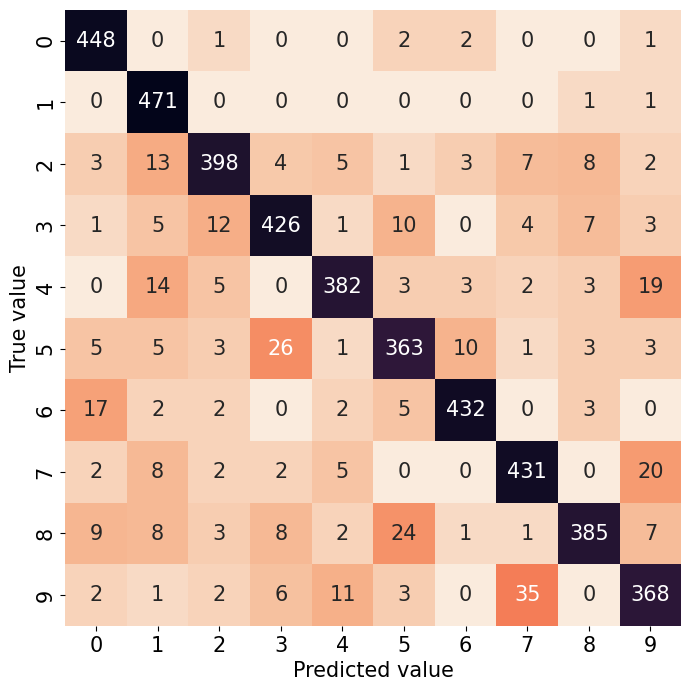

In [20]:
cm = confusion_matrix(test_y, y_pred_knn)
plot_confusion_matrix(cm)

## Neural Networks for Classification

To perform classification with a neural network (NN) we will use the `MLPClassifier` class from `sklearn`. As in the previous tasks reading and understanding the documentation for this class will be necessary for solving the exercises.

Classification with neural networks is inherently more involved than the previous methods we have looked at. This is because neural networks have more hyperparameters, i.e., parameters that need to be determined before training. For Logistic regression there are no essential hyperparameters and for KNN the only essential hyperparameter is k which can be easily determined using cross-validation. 

When setting up a neural network one of the most important considerations is the network architecture, the number of hidden layers and the number of hidden units in each layer. We also have to choose the activation function in each layer. While we can narrow down the optimal value of k in KNN using cross-validation there are simply too many possible architectures for a neural network to use the same approach. Instead we will have to settle for being a bit less rigorous in our approach and using some trial and error to arrive at a good neural network classifier. 

<strong>Task 3:</strong> Train a neural network on the training set using the `MLPClassifier` class. Choose the architecture of the network yourself, i.e., the number of hidden layers, the number of units in each layer and the activation function. Use early stopping to terminate the training process and try to maximize the validation score.  

In [69]:
# Train the neural network and save it here
#testing different layer and nodes



# nn = MLPClassifier(hidden_layer_sizes=(100,),early_stopping=True)
# nn.fit(train_X, train_y)

# nn = MLPClassifier(hidden_layer_sizes=(200,),early_stopping=True)
# nn.fit(train_X, train_y)

# nn = MLPClassifier(hidden_layer_sizes=(300,),early_stopping=True)
# nn.fit(train_X, train_y)

# nn = MLPClassifier(hidden_layer_sizes=(600,),early_stopping=True)
# nn.fit(train_X, train_y)

# nn = MLPClassifier(hidden_layer_sizes=(1000,),early_stopping=True)
# nn.fit(train_X, train_y)

# nn = MLPClassifier(hidden_layer_sizes=(800,),early_stopping=True)
# nn.fit(train_X, train_y)

# nn = MLPClassifier(hidden_layer_sizes=(500,),early_stopping=True)
# nn.fit(train_X, train_y)

# nn = MLPClassifier(hidden_layer_sizes=(200, 150, ),early_stopping=True)
# nn.fit(train_X, train_y)

# nn = MLPClassifier(hidden_layer_sizes=(300, 200, 100,),early_stopping=True)
# nn.fit(train_X, train_y)

nn = MLPClassifier(hidden_layer_sizes=(600, 300, 200,),early_stopping=True)
nn.fit(train_X, train_y)

MLPClassifier(early_stopping=True, hidden_layer_sizes=(600, 300, 200))

The validation accuracy of the final neural network classifier is given by,

In [70]:
nn.best_validation_score_

0.9666666666666667

In [43]:
100 / 0.9504761904761905
200 / 0.9552380952380952
300 / 0.9580952380952381
600 / 0.960952380952381
1000 / 0.9514285714285714
800 / 0.960952380952381 #This give same as 600 nodes...
500 / This gave a lot of different validation scores, some better than 600 nodes, some worse than 100 nodes...

200,150 / 0.9552380952380952

300,200,100 / 0.959047619047619
600,300,200 / 0.9666666666666667

(300, 200, 104.27010923535254)

<strong>Task 4:</strong> Change the initial weights and biases of the network. Does this change the final results? Explain why changing the initial weights and biases may affect the solution of the neural network.

By changing Weights and biases it will change the final results, since its the weights and biases that affects the fit of the final estimated function (the output function), so therefore the fit will not be good and the result of test data will not be very accurate



<strong>Task 5:</strong> How many input units and output units does your neural network have? 

In [44]:
print("Number of input units: 784")
print("Number of output units:", nn.n_outputs_)

Number of input units: 784
Number of output units: 10


Lets evaluate the neural network classifier on the test set. We compute the test accuracy first. 

In [71]:
y_pred_nn = nn.predict(test_X)                # Predicts test labels using NN classifier
test_acc_nn = accuracy(test_y, y_pred_nn)     # Returns test accuracy of NN classifier
test_acc_nn

0.9593333333333334

<strong>Task 6:</strong> Compare the test accuracy to the validation accuracy. In general, the test accuracy will be lower than the validation accuracy. Why is that? 

Because when training the algorithm, there is variable of overfitting the training data when using a very flexible method, and if its overfitted, the accuracy of the test data will not be as accurate as the training/validation accuracy

As before we will also look at the confusion matrix for the NN classifier.

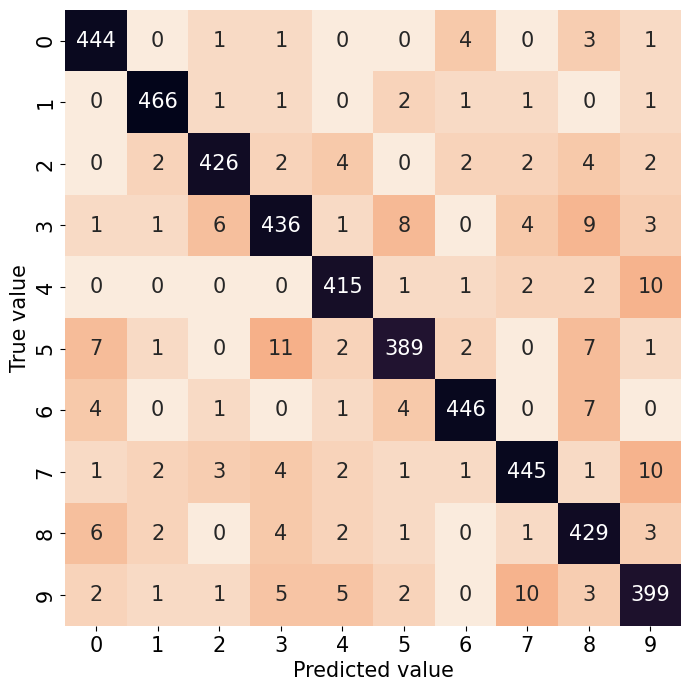

In [55]:
cm = confusion_matrix(test_y, y_pred_nn)
plot_confusion_matrix(cm)

## Final Model Evaluation

Finally, lets compare the test accuracy of all models to see how each one performed on this task.

In [73]:
print('Logistic Regression: ' + str(test_acc_logreg))
print('KNN Classification: ' + str(test_acc_knn))
print('NN Classification: ' + str(test_acc_nn))

Logistic Regression: 0.8875555555555555
KNN Classification: 0.912
NN Classification: 0.9593333333333334
